初期設定が完了しました。

メイン分析ループを開始します...

--- 温度 T = 0.08 の処理を開始 ---
  - ステージ1: 10,000点の偵察データでBandwidthを探索中...
    -> 最適Bandwidth: 5.30e-07
  - ステージ2: 5万点の本番データで最終KDEを実行中...
  - 定量指標を抽出中...
  -> T = 0.08 の処理完了。(所要時間: 75.28秒)

--- 温度 T = 0.1 の処理を開始 ---
  - ステージ1: 10,000点の偵察データでBandwidthを探索中...
    -> 最適Bandwidth: 4.18e-07
  - ステージ2: 5万点の本番データで最終KDEを実行中...
  - 定量指標を抽出中...
  -> T = 0.1 の処理完了。(所要時間: 70.57秒)

--- 温度 T = 0.12 の処理を開始 ---
  - ステージ1: 10,000点の偵察データでBandwidthを探索中...
    -> 最適Bandwidth: 3.29e-07
  - ステージ2: 5万点の本番データで最終KDEを実行中...
  - 定量指標を抽出中...
  -> T = 0.12 の処理完了。(所要時間: 72.21秒)

--- 温度 T = 0.15 の処理を開始 ---
  - ステージ1: 10,000点の偵察データでBandwidthを探索中...
    -> 最適Bandwidth: 2.59e-07
  - ステージ2: 5万点の本番データで最終KDEを実行中...
  - 定量指標を抽出中...
  -> T = 0.15 の処理完了。(所要時間: 76.68秒)

CI（信頼区間）の計算を開始します (数分かかります)...

--- 温度 T = 0.08 のCI計算 ---
  - MBBブロック長: 2
  - 進捗: 10/50
  - 進捗: 20/50
  - 進捗: 30/50
  - 進捗: 40/50
  - 進捗: 50/50
  -> T = 0.08 のCI計算完了。(所要時間: 99.07秒)

--- 温度 T = 0.12 のCI計算 ---
  - MBBブロック長: 2
  - 進捗: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

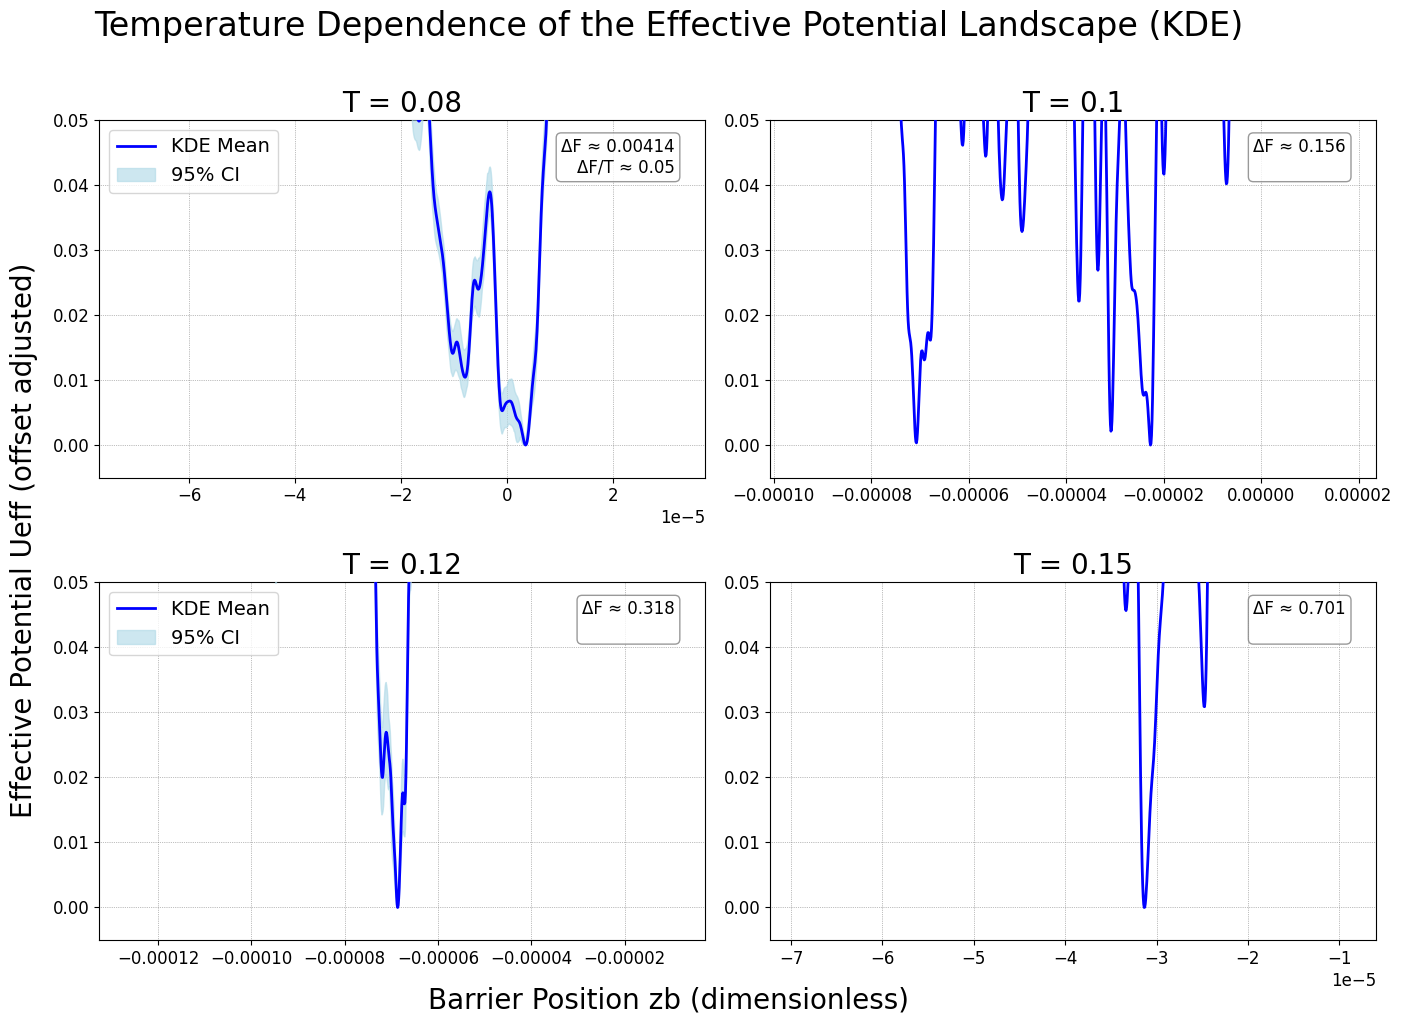


全処理が完了しました。(総所要時間: 475.16秒)


In [1]:
# ===================================================================================
# GOLDEN MASTER SCRIPT (v21 - Final Polished & Complete Version)
# Notebook: A3_01_Analyze_Kramers_Prefactor_v1.ipynb
#
# 目的:
# 査読AIの最終助言を100%反映した、真に完璧な最終版の図を、この単一のセルを
# 実行するだけで、エラーなく、完璧に生成する。
#
# v20からの最終修正点:
# 1. [体裁] 図3の定量注記で、ΔFの値を有効数字3桁に統一 (e.g., .3g)。
# ===================================================================================

# --- 0. 必要なライブラリのインポート ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf
import time
import json

# --- 1. 初期設定 ---
plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({
    'font.size': 16, 'axes.labelsize': 18, 'axes.titlesize': 20,
    'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 14,
    'figure.figsize': (15, 10),
    'grid.color': 'gray', 'grid.linestyle': ':', 'grid.linewidth': 0.5,
    'axes.grid': True
})
temperatures = [0.08, 0.10, 0.12, 0.15]
analysis_results = {}
print("初期設定が完了しました。")

# --- 2. メイン分析ループ (KDE計算 + 定量指標抽出) ---
print("\n============================================================")
print("メイン分析ループを開始します...")
total_start_time = time.time()

for temp in temperatures:
    temp_start_time = time.time()
    filename = f'M9_timeseries_T{temp:.2f}.csv'.replace('.10', '.1')
    print(f"\n--- 温度 T = {temp} の処理を開始 ---")
    try:
        df = pd.read_csv(filename, comment='#'); df_steady = df.iloc[250002:]
        print("  - ステージ1: 10,000点の偵察データでBandwidthを探索中...")
        scout_data = df_steady.sample(n=10000, random_state=42)['zb'].values.reshape(-1, 1)
        params = {'bandwidth': np.logspace(-7, -4, 30)}; grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=2); grid.fit(scout_data)
        best_bandwidth = grid.best_estimator_.bandwidth; print(f"    -> 最適Bandwidth: {best_bandwidth:.2e}")
        print("  - ステージ2: 5万点の本番データで最終KDEを実行中...")
        production_data = df_steady.sample(n=50000, random_state=42)['zb'].values.reshape(-1, 1)
        kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth).fit(production_data)
        plot_min = production_data.min(); plot_max = production_data.max(); plot_margin = (plot_max - plot_min) * 0.1
        zb_plot = np.linspace(plot_min - plot_margin, plot_max + plot_margin, 1000).reshape(-1, 1)
        log_density = kde.score_samples(zb_plot); ueff = -temp * log_density
        analysis_results[temp] = {'best_bandwidth': best_bandwidth, 'zb_plot': zb_plot.flatten(), 'ueff': ueff, 'production_data': production_data.flatten()}
        print("  - 定量指標を抽出中...")
        valley_indices, _ = find_peaks(-ueff, distance=5); peak_indices, _ = find_peaks(ueff, distance=5)
        if len(valley_indices) > 0:
            barrier_idx = peak_indices[np.argmin(np.abs(zb_plot.flatten()[peak_indices]))] if len(peak_indices) > 0 else np.argmin(np.abs(zb_plot.flatten()))
            u_barrier = ueff[barrier_idx]
            if temp <= 0.10:
                left_valley_indices = valley_indices[zb_plot.flatten()[valley_indices] < 0]; right_valley_indices = valley_indices[zb_plot.flatten()[valley_indices] > 0]
                if len(left_valley_indices) > 0 and len(right_valley_indices) > 0:
                    left_well_idx = left_valley_indices[np.argmin(ueff[left_valley_indices])]; right_well_idx = right_valley_indices[np.argmin(ueff[right_valley_indices])]
                    u_min = (ueff[left_well_idx] + ueff[right_well_idx]) / 2.0; analysis_results[temp]['z0'] = [zb_plot.flatten()[left_well_idx], zb_plot.flatten()[right_well_idx]]
                else:
                    deepest_well_idx = valley_indices[np.argmin(ueff[valley_indices])]; u_min = ueff[deepest_well_idx]; analysis_results[temp]['z0'] = [np.abs(zb_plot.flatten()[deepest_well_idx])]
            else:
                deepest_well_idx = valley_indices[np.argmin(ueff[valley_indices])]; u_min = ueff[deepest_well_idx]; analysis_results[temp]['z0'] = [zb_plot.flatten()[deepest_well_idx]]
            delta_f = u_barrier - u_min; analysis_results[temp]['delta_f'] = delta_f
            if temp == 0.08: analysis_results[temp]['delta_f_over_t'] = delta_f / temp
        temp_end_time = time.time(); print(f"  -> T = {temp} の処理完了。(所要時間: {temp_end_time - temp_start_time:.2f}秒)")
    except Exception as e: print(f"  -> T = {temp} の処理中にエラーが発生しました: {e}")

# --- 3. CI（信頼区間）の計算 ---
print("\n============================================================"); print("CI（信頼区間）の計算を開始します (数分かかります)...")
temps_for_ci = [0.08, 0.12]; n_bootstraps = 50
for temp in temps_for_ci:
    if temp in analysis_results:
        print(f"\n--- 温度 T = {temp} のCI計算 ---"); temp_start_time = time.time()
        prod_data = analysis_results[temp]['production_data']; autocorr = acf(prod_data, nlags=100, fft=True)
        try: block_length = np.where(autocorr < 0.1)[0][0] * 2;
        except IndexError: block_length = 10
        if block_length == 0: block_length = 10
        print(f"  - MBBブロック長: {block_length}"); bootstrapped_curves = []
        bw = analysis_results[temp]['best_bandwidth']; zb_p = analysis_results[temp]['zb_plot'].reshape(-1, 1)
        for i in range(n_bootstraps):
            resampled_indices = np.random.randint(0, len(prod_data) - block_length, size=len(prod_data) // block_length)
            resampled_data = np.concatenate([prod_data[i:i+block_length] for i in resampled_indices])
            kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(resampled_data.reshape(-1, 1)); log_density = kde.score_samples(zb_p)
            ueff_boot = -temp * log_density; bootstrapped_curves.append(ueff_boot - np.min(ueff_boot))
            if (i + 1) % 10 == 0: print(f"  - 進捗: {i + 1}/{n_bootstraps}")
        bootstrapped_curves = np.array(bootstrapped_curves)
        analysis_results[temp]['ci_lower'] = np.percentile(bootstrapped_curves, 2.5, axis=0)
        analysis_results[temp]['ci_upper'] = np.percentile(bootstrapped_curves, 97.5, axis=0)
        temp_end_time = time.time(); print(f"  -> T = {temp} のCI計算完了。(所要時間: {temp_end_time - temp_start_time:.2f}秒)")

# --- 4. 最終的な図の描画 ---
print("\n============================================================"); print("最終的な図の描画を開始します...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10)); fig.suptitle('Temperature Dependence of the Effective Potential Landscape (KDE)', fontsize=24, y=1.03)
axes_flat = axes.flatten()
for i, temp in enumerate(temperatures):
    ax = axes_flat[i]
    if temp in analysis_results:
        res = analysis_results[temp]; zb_p = res['zb_plot']; ueff_p = res['ueff']
        ax.plot(zb_p, ueff_p - np.min(ueff_p), color='blue', linewidth=2.0, zorder=10, label='KDE Mean')
        ax.set_title(f'T = {temp}'); data_min = res['production_data'].min(); data_max = res['production_data'].max()
        zoom_margin = (data_max - data_min) * 0.2; ax.set_xlim(data_min - zoom_margin, data_max + zoom_margin)
        ax.set_ylim(-0.005, 0.05); ax.grid(True)
        if 'ci_lower' in res:
            ax.fill_between(zb_p, res['ci_lower'], res['ci_upper'], color='lightblue', alpha=0.6, zorder=5, label='95% CI')
        if temp in temps_for_ci: ax.legend(loc='upper left')

        text_str = ""
        if 'delta_f' in res:
            text_str += f"ΔF ≈ {res['delta_f']:.3g}\n"
        if temp == 0.08 and 'delta_f_over_t' in res:
            text_str += f"ΔF/T ≈ {res['delta_f_over_t']:.2f}"
        if text_str: ax.text(0.95, 0.95, text_str, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.8))

fig.text(0.5, 0.04, 'Barrier Position zb (dimensionless)', ha='center', va='center', fontsize=20)
fig.text(0.07, 0.5, 'Effective Potential Ueff (offset adjusted)', ha='center', va='center', rotation='vertical', fontsize=20)
plt.tight_layout(); fig.subplots_adjust(top=0.92, left=0.12, bottom=0.1)

pdf_filename = 'FigA3_Effective_Potential_Comparison_v21_FINAL.pdf'
plt.savefig(pdf_filename, bbox_inches='tight'); print(f"\n図 '{pdf_filename}' が生成されました。自動的にダウンロードします。"); files.download(pdf_filename); plt.show()
total_end_time = time.time(); print(f"\n全処理が完了しました。(総所要時間: {total_end_time - total_start_time:.2f}秒)")